# Time Molecule with dissipation

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import *
from scipy.constants import e, h, hbar
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import random
import scipy.linalg as la
from scipy.linalg import expm, sinm, cosm
import pandas
import numpy
from tqdm import tqdm, tnrange, tqdm_notebook
from ipypb import irange
from ipypb import track
from time import sleep

C:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from ipywidgets import IntProgress         # This is a progress bar, it is optional.
from IPython.display import display
import time

In [4]:
def PauliMatrix (n):                             # Pauli Matrices
    if n == 0:
        return  [[1, 0], [0, 1]]
    if n == 1:
        return  [[0, 1], [1, 0]]
    if n == 2:
        return  [[0, -1j], [1j, 0]]
    if n == 3:
        return  [[1, 0], [0, -1]]
    if n == 4:
        return  [[1, 0], [0, 1]]
    return print ('WRONG Pauli Matrix ID')

A set of functions for calculating Time Molecule without dissipation

In [20]:
def tensorize1SiteMatrixKroneker(nSites, nSite, nPauli):        
    A = zeros(nSites - nSite) 
    B = zeros(nSite - 1)
    C = []
    for i in B:
        C.append(int(i))
    C.append(nPauli)
    for i in A:
        C.append(int(i)) 
    D = []    
    for i in C:
        D.append(PauliMatrix(i))   
    D1=D[0]
    for i in range(1, nSites,1):
        D1=kron(D1,D[i])
    return D1

def fixedLineKK(nSites, k):
    E = []
    for i in range(0, nSites - 1,1):
        E.append(np.dot(tensorize1SiteMatrixKroneker(nSites, i+1, k),tensorize1SiteMatrixKroneker(nSites, i+2, k)))
    return E

def fixedLocalK(nSites, k):
    F = []
    for i in range(0, nSites,1):
        F.append(tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return F
def disorderedLocalK(nSites, k):
    G = []
    for i in range(0, nSites,1):
        G.append(random.random()*tensorize1SiteMatrixKroneker(nSites, i+1, k))
    return G

def deltaS (w, sitesN):                      # The function produces a uniform spread of spin frequencies (disorder)
    H = []
    H.append(0)
    for i in range(1, sitesN,1):
        H.append(i*w/(sitesN-1))
    return H

def states(phiInitFull, Time):               # Calculation of the evolution of the state of the system
    A = np.array([phiInitFull])
    for i in range(0, Time-1,1):
        A = np.append(A, [np.dot(U,A[i])], 0)
    return A

In [21]:
def chop(expr, *, max=0.01):    # A strange function that removes unnecessary decimal numbers
    return [np.round(i,3) if abs(i) > max else 0 for i in expr]

def matrix_chop(matrix):        # Same for a matrix
    T = []
    for i in matrix:
        T.append(chop(i))
    return T

Functions for the Lindbladian Time Molecule

In [22]:
def identity_matrix(demention):                 
    I = np.zeros((demention,demention), dtype=float)
    for i in arange(0,demention):
        I[i][i]=1
    return I

def sigma_minus():
    return [[0,0],[1,0]]
def sigma_plus():
    return [[0,1],[0,0]]

just in case of periodic boundary conditions, so if there is a $\sum_{i = (1 .. nSpins)}$, for 2-spin operators, the last one will be periodic : from the first to the last spin

In [23]:
def iFunc(n,x):
    if (x <= n):
        return x
    else:
        return x-n

*Turning local operators into global ("tensorized") operators of a many - body system. $m_1$, $m_2$ -- local operators, $i_1$, $i_2$ -- locations of the corresponding spins*

In [24]:
def twoSiteOpearatorTensorization(matrix1, matrix2, i1, i2, nSites):
    T = []
    for i in arange(nSites):
        if (i == iFunc(nSites,i1)-1):
            T.append(matrix1)
        if (i == iFunc(nSites,i2)-1):
            T.append(matrix2)
        if ((i!=iFunc(nSites,i1)-1)&(i!=iFunc(nSites,i2)-1)):
            T.append(PauliMatrix(0))
                   
    mat = kron(T[0],T[1])
    for i in arange(nSites-2):
        mat = kron(mat,T[i])
    return mat

def oneSiteOpearatorTensorization(matrix, i, nSites):
    return twoSiteOpearatorTensorization(matrix, identity_matrix(2),i,i+1,nSites) 

Lindbladization of hamiltonian and dissipation operators

In [25]:
def hamiltonianToLindblad(h):
    return -1j*(-kron(np.matrix(h).T,identity_matrix(int(np.sqrt(size(h)))))+kron(identity_matrix(int(np.sqrt(size(h)))),np.matrix(h)))

In [26]:
def jumpOperatorToLindblad(a):
    n = int(np.sqrt(size(a)))
    return kron(conj(a),a)-0.5*(kron(identity_matrix(n),dot(conj(a).T,a))+kron(dot(conj(a).T,a).T,identity_matrix(n)))

vectorization of the density matrix and reverse

In [27]:
def flatDensityMatrixToFull(m):
    return m.reshape(int(np.sqrt(size(m))), int(np.sqrt(size(m)))).T
def fullDensityMatrixToflat(m):
    return m.T.reshape(-1, 1)

Concurrence function

In [28]:
def concurrence(RHO):
    rhot = np.dot(np.dot(kron(PauliMatrix(2),PauliMatrix(2)), conj(RHO)),kron(PauliMatrix(2),PauliMatrix(2)))
    eigs = la.fractional_matrix_power(np.dot(np.dot(la.fractional_matrix_power(RHO, 1/2),rhot),la.fractional_matrix_power(RHO, 1/2)),1/2)
    evals, evecs = la.eig(eigs) 
    evals = sort(evals)
    return (max(0,evals[3]-evals[2]-evals[1]-evals[0]))

Interaction and evolution

In [29]:
def Ufunc_all_to_all(nSites,alpha,g,T,delta):      # Function U specifying the evolution of a system without dissipation
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                #print(i,j)
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, j, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, j, 2))
    
    return np.dot(expm(-1j*alpha*X),expm((-1j*T*(Z+g*xxyy)))) 

def Ufunc_all_to_all_lind(nSites,alpha,g,T,delta,disOps):  # Function U specifying the evolution of a system with dissipation
    X = tensorize1SiteMatrixKroneker(nSites, 1, 1)                        # spins rotation
    Z = delta[0]*tensorize1SiteMatrixKroneker(nSites, 1, 3)               # spins with disorder
    for i in range(2, nSites+1,1):
        X = X + tensorize1SiteMatrixKroneker(nSites, i, 1)
        Z = Z + delta[i-1]*tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    xxyy = np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1)) - \
           np.dot(tensorize1SiteMatrixKroneker(nSites, 1, 1),tensorize1SiteMatrixKroneker(nSites, 2, 1))            #interaction
    for i in range(1, nSites+1,1):
        for j in range(1,nSites+1,1):
            if i<j:
                #print(i,j)
                xxyy = xxyy + np.dot(tensorize1SiteMatrixKroneker(nSites, i, 1),tensorize1SiteMatrixKroneker(nSites, j, 1)) + \
                    np.dot(tensorize1SiteMatrixKroneker(nSites, i, 2),tensorize1SiteMatrixKroneker(nSites, j, 2))
                    
    Xlindbladian=hamiltonianToLindblad(X)
    Zlindbladian=hamiltonianToLindblad(Z)
    xxyylindbladian=hamiltonianToLindblad(xxyy)
    
                    
    collapse = np.zeros((nSites**4,nSites**4), dtype=float)
    for i in arange(3*nSites): 
        collapse  = collapse  + jumpOperatorToLindblad(disOps[i])
    
    return np.dot(expm(alpha*Xlindbladian),expm((T*(Zlindbladian+g*xxyylindbladian+collapse))))
    
def states_lind(phiInitFull, func, Time):   # evolution of the system with dissipation
    A = np.array([phiInitFull])
    for i in range(0, Time-1,1):
        A = np.append(A, [np.dot(func,A[i])], 0)
    return A

In [30]:
def Piecewisese(Matrix):                                   #Function to visualize three region of the equilibration time
    New = np.zeros((eps_steps,g_steps), dtype=float)
    for g_id, g_value in enumerate(g): 
        for alpha_id, alpha_value in enumerate(alpha): 
            if Matrix[alpha_id][g_id]>Matrix[alpha_id-1][g_id]:
                New[alpha_id][g_id] = 1
            if Matrix[alpha_id][g_id]<Matrix[alpha_id-1][g_id]:
                New[alpha_id][g_id] = -1
            if abs(Matrix[alpha_id][g_id]-Matrix[alpha_id-1][g_id])<10e-4:
                New[alpha_id][g_id] = 0
    return New     

# Variable Parameters  - eps

Let's draw the evolution of a 2-spin system prepared to create a Time molecule with dissipation.

In [37]:
nSites = 2 

eps_steps = 150
eps=np.linspace(0.0*np.pi, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                          #disorder
delta = [0,0]
g = 0.05                                          #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [38]:
g1 = 0.01            # relaxation rate
g2 = 0.0025          # dephasing rate
n_th = 0.01          # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

values are found as $Tr(j\rho(t))$

In [39]:
Observables = np.zeros((eps_steps,time_steps), dtype=complex128)
RHO = np.zeros((eps_steps,time_steps,2**nSites,2**nSites), dtype=list)
Concur = np.zeros((eps_steps,time_steps), dtype=complex128)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)              # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))


    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states
    
    rho_s = []
    conccc = []
    Temp = []
    for i in arange(time_steps):
        Temp.append(flatDensityMatrixToFull(Final[i]))
        rho_s.append(flatDensityMatrixToFull(Final[i]))
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))
    Final = Temp

    observables = []
      
    for i in Final:
        observables.append(np.dot(sigZOp,i).trace())
    
    f.value += 1
    Observables[alpha_id] = observables 
    RHO[alpha_id] = rho_s
    Concur[alpha_id] = conccc

IntProgress(value=0, max=150)

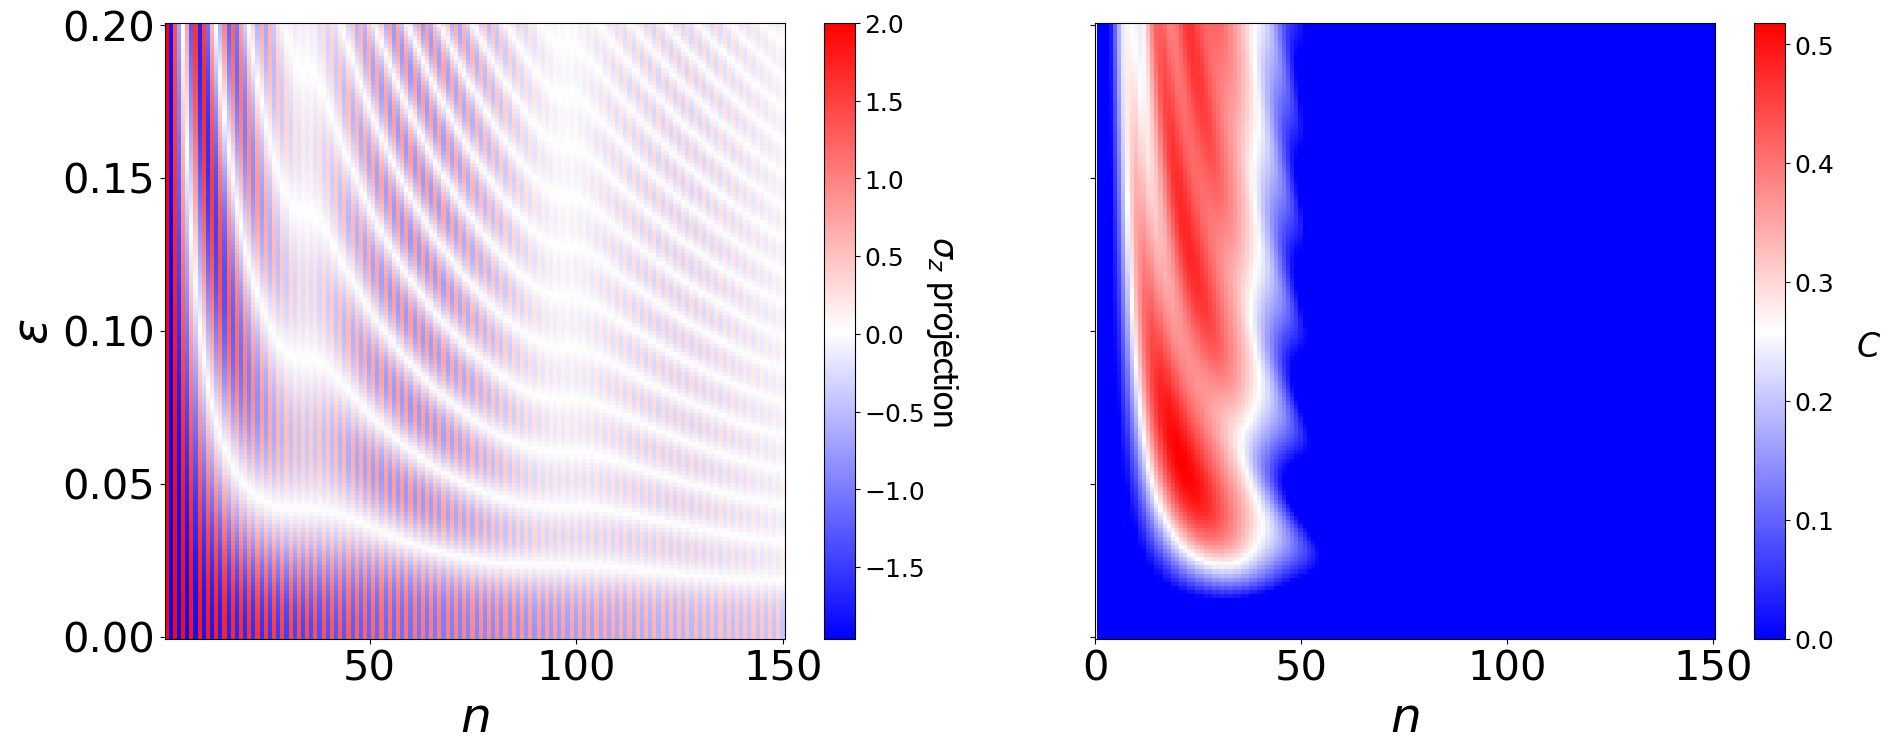

In [40]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(22, 8))

p = axes[0].pcolor(times, eps, real(Observables), cmap=cm.bwr, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\varepsilon$', fontsize=35, **hfont, rotation=90)
axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$\sigma_z$ projection', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 
#---------------------------------------------------------------------------
p = axes[1].pcolor(times, eps, real(Concur), cmap=cm.bwr, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)
axes[1].set_yticklabels([])
axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$C$', labelpad=25, rotation=0, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

crosssection of the previous plot

C:\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 150.0)

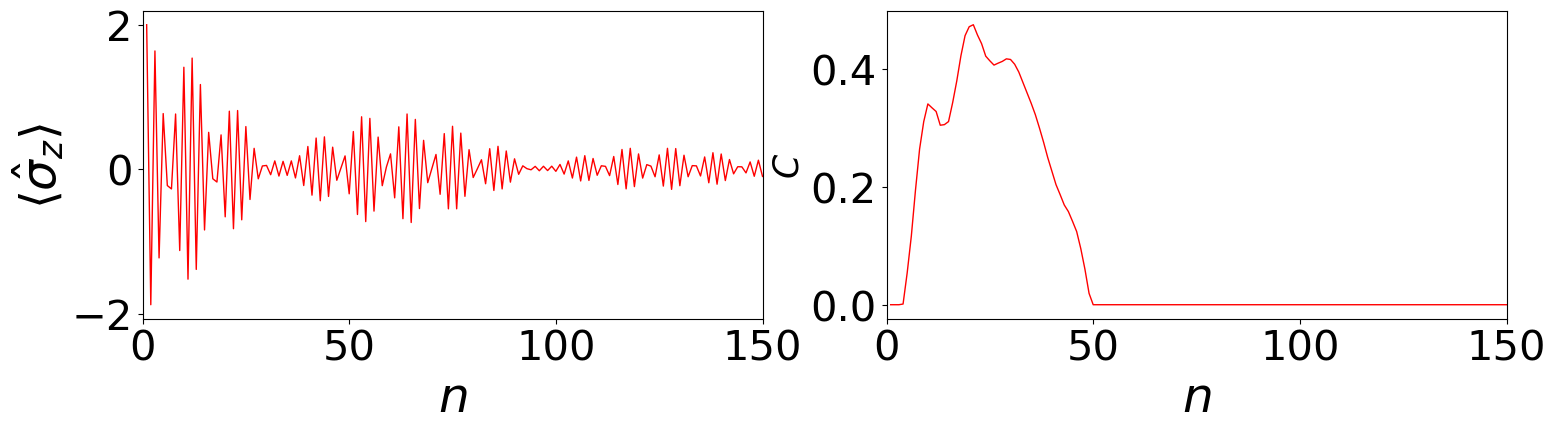

In [41]:
number =   109   

hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,2,figsize=(17.6, 4))

p = axes[0].plot(times, Observables[number], 'r', linewidth=1.0)

axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\langle \hat{\sigma}_z \rangle$', fontsize=35, rotation=90, **hfont)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

p = axes[1].plot(times, Concur[number], 'r', linewidth=1.0)

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[1].set_ylabel(r'$C$', fontsize=25, **hfont)

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

axes[0].set_xticks(np.round(np.linspace(0, 150, 4), 2))
axes[0].set_xlim(0.0,150)
axes[1].set_xlim(0.0,150)

# Variable Parameters - g_1

In [42]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                     #disorder
delta = [0,0]
g = 0.05                                     #Interaction
T = 1  
time_steps = 150
times = np.linspace(1, time_steps, time_steps)

In [43]:
g1 = 0.001        # relaxation rate
g2 = 0.00025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [44]:
Concur_1 = np.zeros((eps_steps,time_steps), dtype=complex128)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_1[alpha_id] = conccc

IntProgress(value=0, max=500)

KeyboardInterrupt: 

In [40]:
g1 = 0.005        # relaxation rate
g2 = 0.00125        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [41]:
Concur_2 = np.zeros((eps_steps,time_steps), dtype=complex128)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_2[alpha_id] = conccc

IntProgress(value=0, max=500)

In [42]:
g1 = 0.01        # relaxation rate
g2 = 0.0025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [43]:
Concur_3 = np.zeros((eps_steps,time_steps), dtype=complex128)

f = IntProgress(min=0, max=eps_steps) # instantiate the bar
display(f) # display the bar

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    

for alpha_id, alpha_value in enumerate(alpha): 
    
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    phiInitFull = np.full((2**nSites), 0)          # initial state - all spins up
    phiInitFull[0] = 1
    initialStateDensityMatrix = fullDensityMatrixToflat(kron(phiInitFull.conj(),phiInitFull))

    Final = states_lind(initialStateDensityMatrix,U,time_steps)                ## Evolution of states

    conccc = []

    for i in arange(time_steps):
        conccc.append(concurrence(flatDensityMatrixToFull(Final[i])))

    f.value += 1
    Concur_3[alpha_id] = conccc

IntProgress(value=0, max=500)

Text(125, 0.185, '(c)')

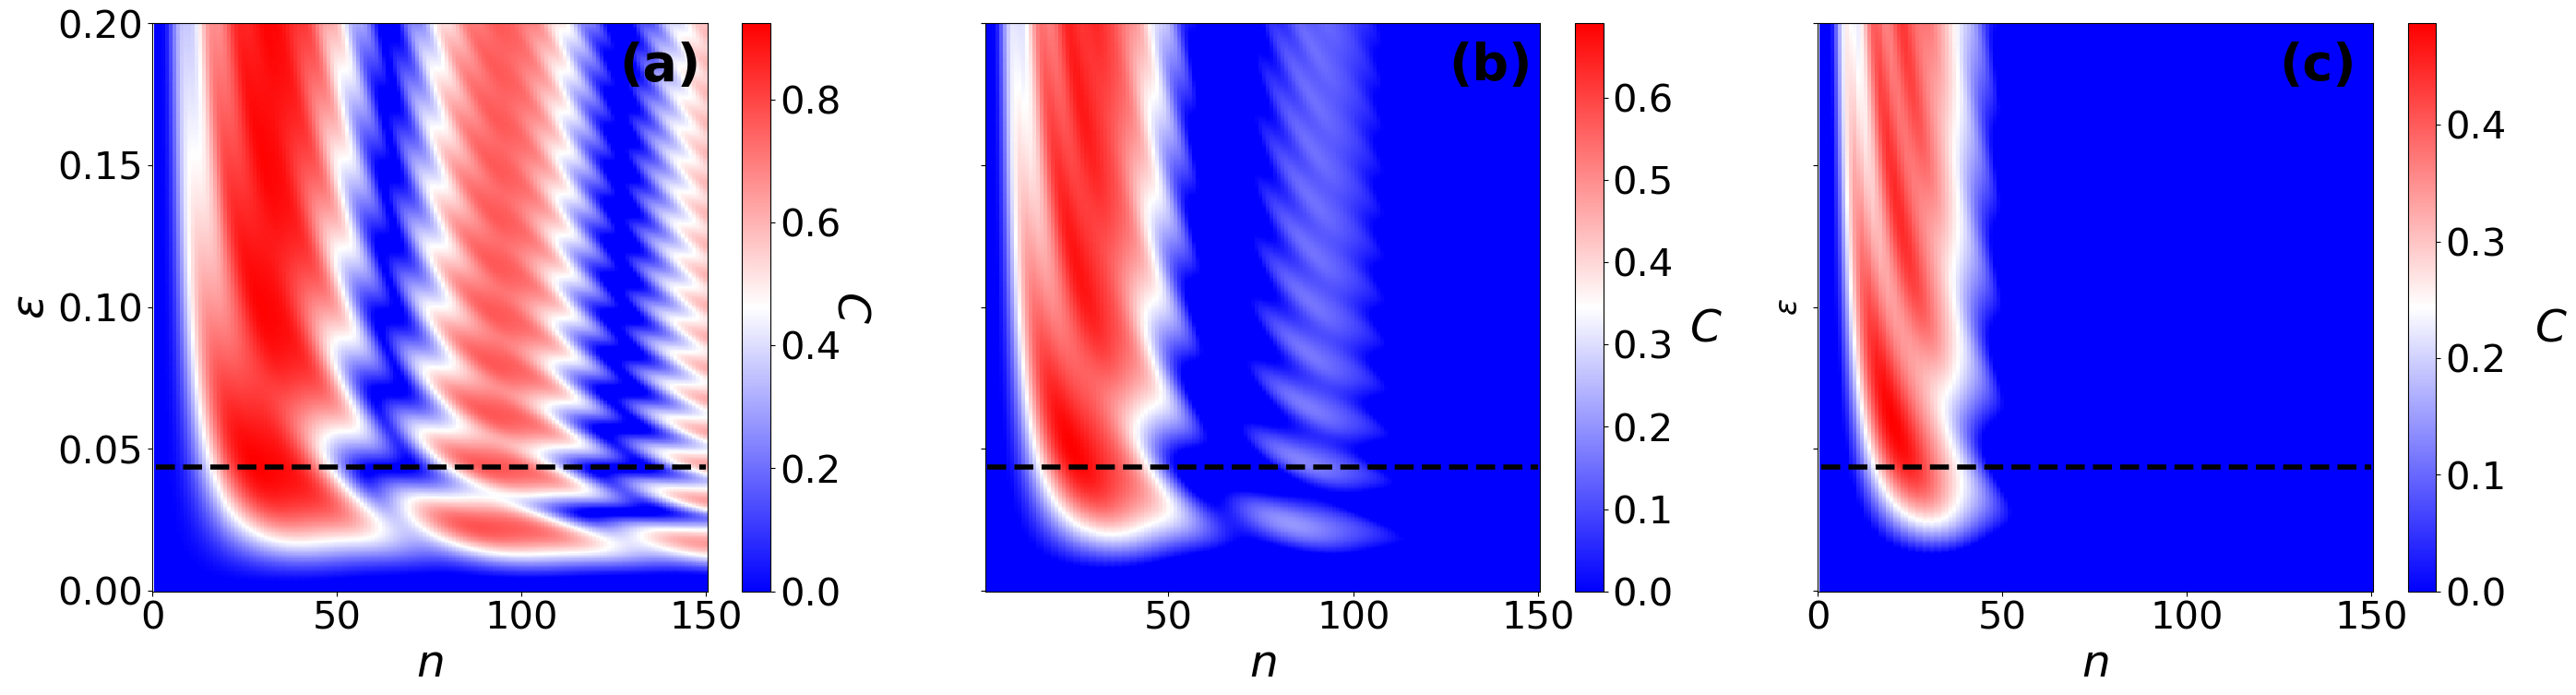

In [44]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,3,figsize=(33, 8))

#plt.rcParams["text.usetex"] = True

p = axes[0].pcolor(times, eps, real(Concur_1), cmap=cm.bwr, shading='nearest')

axes[0].axis('tight')
axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$\epsilon$', fontsize=35, **hfont, rotation=90)


axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'$C$', labelpad=25, rotation=270, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30) 

#cb.remove()

ymin, ymax = axes[0].get_ylim()
axes[0].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[0].get_xlim()
axes[0].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

p = axes[1].pcolor(times, eps, real(Concur_2), cmap=cm.bwr, shading='nearest')

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

axes[1].set_yticklabels([])

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[1].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

#axes[1].set_xlim((0.4, 0.6))

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'$C$', labelpad=25, rotation=0, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30)

#cb.remove()

ymin, ymax = axes[1].get_ylim()
axes[1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------
p = axes[2].pcolor(times, eps, real(Concur_3), cmap=cm.bwr, shading='nearest')

axes[2].axis('tight')
axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[2].set_ylabel(r'$\epsilon$', fontsize=24, **hfont)

axes[2].tick_params(axis='x', labelsize=30)
axes[2].tick_params(axis='y', labelsize=30)

axes[2].set_yticklabels([])
cb = fig.colorbar(p, ax=axes[2])
cb.set_label(r'$C$', labelpad=35, rotation=0, fontsize=35, **hfont)
cb.ax.tick_params(labelsize=30)

ymin, ymax = axes[2].get_ylim()
axes[2].set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))

xmin, xmax = axes[2].get_xlim()
axes[2].set_xticks(np.round(np.linspace(xmin-0.5, xmax-0.5, 4), 2))

#---------------------------------------------------------------------------

axes[0].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
axes[1].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)
axes[2].plot(times,  times-times+0.0436, 'k--', linewidth=4.0)


matplotlib.pyplot.text(-325, 0.185, '(a)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text(-100, 0.185, '(b)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( 125, 0.185, '(c)', fontsize=40, weight="black",  verticalalignment='center')

(0.0, 150.0)

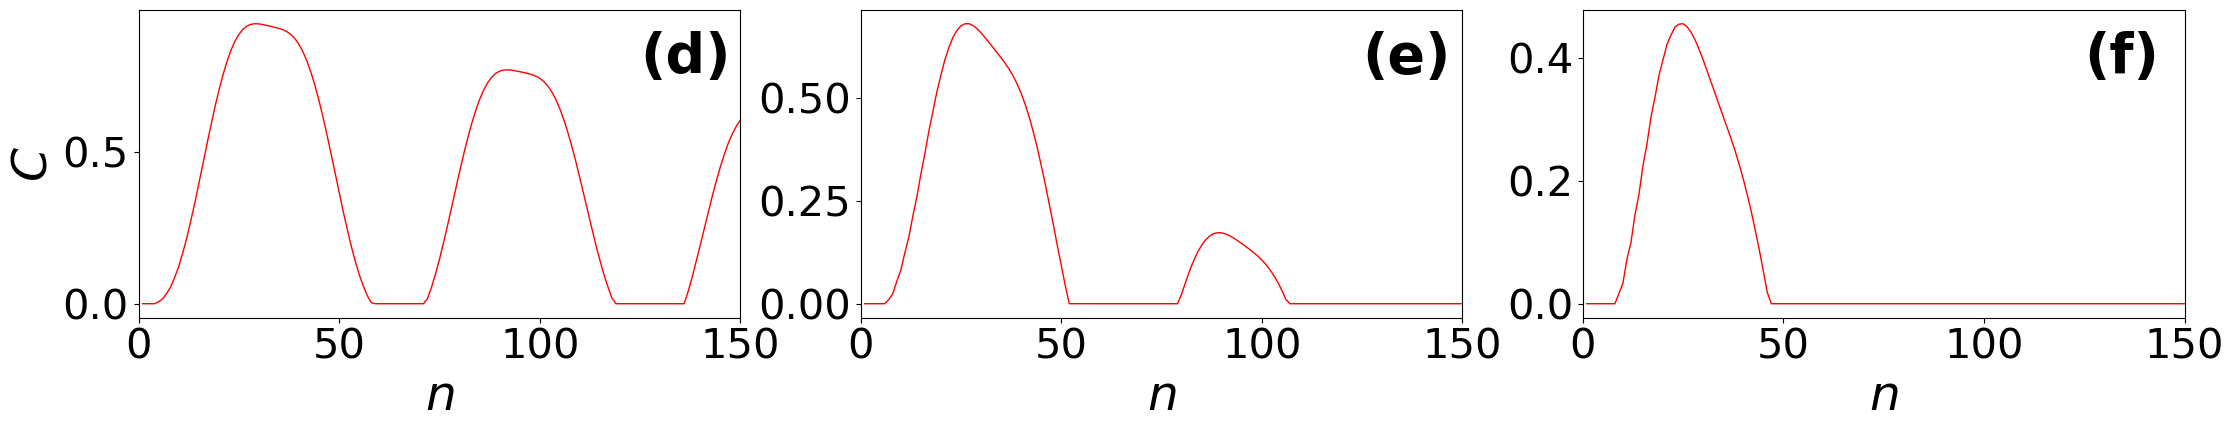

In [45]:
number =   109     #244

hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,3,figsize=(26.4, 4))

#plt.rcParams["text.usetex"] =True

p = axes[0].plot(times, Concur_1[number], 'r', linewidth=1.0)

axes[0].set_xlabel(r'$n$', fontsize=35, **hfont)
axes[0].set_ylabel(r'$C$', fontsize=35, rotation=90, **hfont)

axes[0].tick_params(axis='x', labelsize=30)
axes[0].tick_params(axis='y', labelsize=30)

p = axes[1].plot(times, Concur_2[number], 'r', linewidth=1.0)

axes[1].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[1].set_ylabel(r'$C$', fontsize=25, **hfont)

axes[1].tick_params(axis='x', labelsize=30)
axes[1].tick_params(axis='y', labelsize=30)

p = axes[2].plot(times, Concur_3[number], 'r', linewidth=1.0)

axes[2].set_xlabel(r'$n$', fontsize=35, **hfont)
#axes[2].set_ylabel(r'$С$', fontsize=25, **hfont)

axes[2].tick_params(axis='x', labelsize=30)
axes[2].tick_params(axis='y', labelsize=30)

matplotlib.pyplot.text(-235, 0.4, '(d)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( -55, 0.4, '(e)', fontsize=40, weight="black",  verticalalignment='center')
matplotlib.pyplot.text( 125, 0.4, '(f)', fontsize=40, weight="black",  verticalalignment='center')

axes[0].set_xticks(np.round(np.linspace(0, 150, 4), 2))
axes[0].set_xlim(0.0,150)
axes[1].set_xlim(0.0,150)
axes[2].set_xlim(0.0,150)

#plt.gcf().set_size_inches(26.5, 4)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/Time-Molecule/TM_Pic1def.pdf", bbox_inches="tight")

#axes[1].set_xlim((0.475, 0.525))

Spectral gap calculation

In [244]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.00, 0.3, eps_steps)        #unperfection of pulses
alpha = np.pi/2-eps
w = 0.00                                     #disorder
delta = [0,0]
g = 0.05*np.pi                               #Interaction
T = 1  

In [254]:
g1 = 0.01        # relaxation rate
g2 = 0.0025        # dephasing rate
n_th = 0.08       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(), identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2), sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [252]:
Spectral_gap = []
Eigen_Values = []
Super_Matrix = []

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
    U=Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
    evals, evecs = la.eig(U)
    Super_Matrix.append(U)
    Spectral_gap.append(1/(-log(sort(abs(evals)))[-2]))
    Eigen_Values.append(evals)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 607.89it/s]


Text(0, 0.5, '$t_{eq}$')

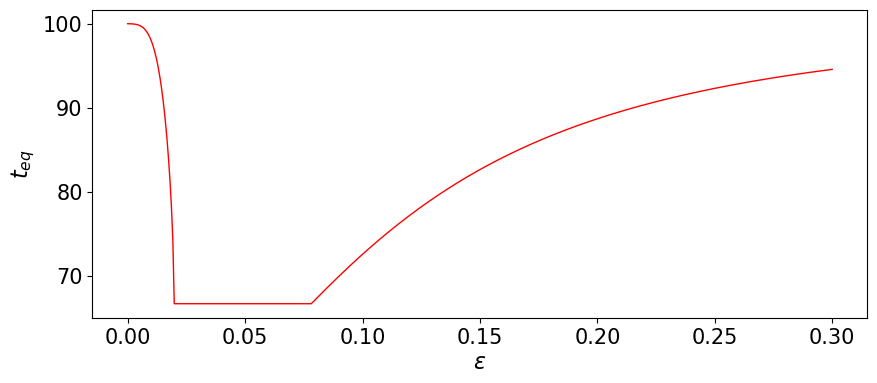

In [253]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 4))

p = axes.plot(eps, Spectral_gap, 'r', linewidth=1.0)

axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [276]:
eps_steps = 500
eps=np.linspace(0.00, 0.2, eps_steps)        #unperfection of pulses

In [277]:
def equlibrium_time_calc(g, n_th, g1, g2, nSites, alpha, T, delta):
    
    #g1       # relaxation rate
    #g2       # dephasing rate
    #n_t      # bath temperature
    
    c_ops = []
    # qubit 1 collapse operators
    sm1 = kron(sigma_minus(),identity_matrix(2))
    sz1 = kron(PauliMatrix(3), identity_matrix(2))
    c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
    c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
    c_ops.append(np.sqrt(g2) * sz1)

    # qubit 2 collapse operators
    sm2 = kron(identity_matrix(2),sigma_minus())  
    sz2 = kron(identity_matrix(2), PauliMatrix(3))
    c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
    c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
    c_ops.append(np.sqrt(g2) * sz2)
    
    Spectral_gap = []
    Eigen_Values = []
    Super_Matrix = []

    sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
    for i in range(2, nSites+1,1):
        sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
    for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
        U = Ufunc_all_to_all_lind(nSites,alpha_value,g,T,delta,c_ops)
        evals, evecs = la.eig(U)
        Super_Matrix.append(U)
        Spectral_gap.append(1/(-log(sort(abs(evals)))[-2]))
        Eigen_Values.append(evals)
    return Spectral_gap

In [281]:
Spec0 = equlibrium_time_calc(0.05*np.pi,  0.0, 0.01, 0.0025, 2, alpha,T, delta)
Spec8 = equlibrium_time_calc(0.05*np.pi,  0.3, 0.01, 0.0025, 2, alpha,T, delta)
Spec2 = equlibrium_time_calc(0.05*np.pi,  0.6, 0.01, 0.0025, 2, alpha,T, delta)    #(g, n_th, g1, g2, nSites, alpha, T, delta)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.05it/s]


Text(0, 0.5, '$t_{eq}$')

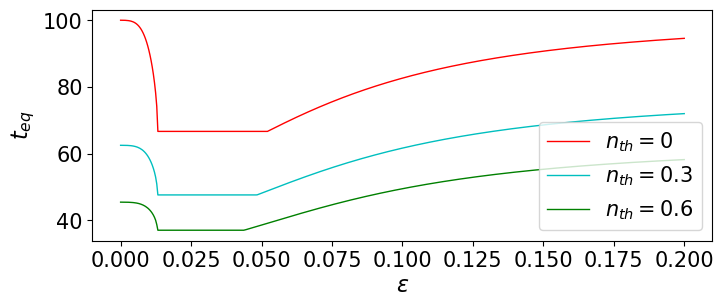

In [282]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$n_{th} = 0$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$n_{th} = 0.3$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$n_{th} = 0.6$')

axes.legend(loc = 'lower right')
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

In [56]:
Spec0 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.005, 0.0025)
Spec8 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.01, 0.0025)
Spec2 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.02, 0.0025)
Spec3 = equlibrium_time_calc(0.05*np.pi, 0.08, 0.03, 0.0025)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 733.17it/s]


Text(0, 0.5, '$t_{eq}$')

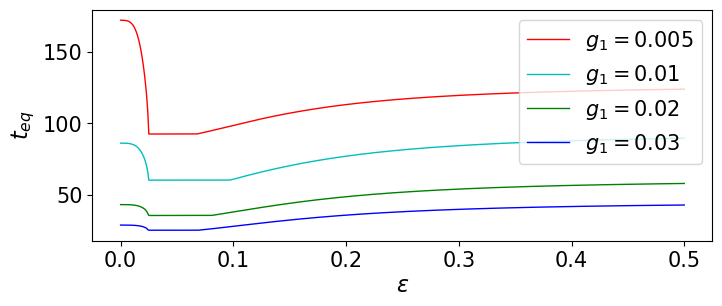

In [57]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 3))

p = axes.plot(eps, Spec0,  'r', linewidth=1.0, label = '$g_1 = 0.005$')
p = axes.plot(eps, Spec8,  'c', linewidth=1.0, label = '$g_1 = 0.01$')
p = axes.plot(eps, Spec2,  'g', linewidth=1.0, label = '$g_1 = 0.02$')
p = axes.plot(eps, Spec3,  'b', linewidth=1.0, label = '$g_1 = 0.03$')

axes.legend(loc="upper right")
axes.set_xlabel(r'$\epsilon$', fontsize=16, **hfont)
axes.set_ylabel(r'$t_{eq}$', fontsize=16, **hfont)

Spectrap gap for the different interactions

In [57]:
nSites = 2 

eps_steps = 500
eps=np.linspace(0.0, 0.2, eps_steps)                        #unperfection of pulses
#eps=np.linspace(0.13*np.pi, 0.131*np.pi, eps_steps)        #unperfection of pulses   artifact
alpha = np.pi/2-eps
w = 0.00                                        #disorder
delta = [0,0]
T = 1  
g_steps = 500
g = np.linspace(0.0, 0.5*np.pi, g_steps)                                 #Interaction
#g = np.linspace(0.9088*np.pi, 0.9093*np.pi, g_steps)                    #Interaction   artifact

In [58]:
g1 = 0.01        # relaxation rate
g2 = 0.0025       # dephasing rate
n_th = 0.5       # bath temperature

##----------------------------------------------------

c_ops = []
# qubit 1 collapse operators
sm1 = kron(sigma_minus(),identity_matrix(2))
sz1 = kron(PauliMatrix(3), identity_matrix(2))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.T.conj())
c_ops.append(np.sqrt(g2) * sz1)

# qubit 2 collapse operators
sm2 = kron(identity_matrix(2),sigma_minus())  
sz2 = kron(identity_matrix(2), PauliMatrix(3))
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.T.conj())
c_ops.append(np.sqrt(g2) * sz2)

In [59]:
Spectral_gap = np.zeros((eps_steps,g_steps), dtype=float)

sigZOp = tensorize1SiteMatrixKroneker(nSites, 1, 3)
for i in range(2, nSites+1,1):
    sigZOp = sigZOp + tensorize1SiteMatrixKroneker(nSites, i, 3)
    
for alpha_id, alpha_value in enumerate(tqdm(alpha)): 
    spec_gap = []
    for g_id, g_value in enumerate(g): 
        U=Ufunc_all_to_all_lind(nSites,alpha_value,g_value,T,delta,c_ops)
        evals, evecs = la.eig(U)
        spec_gap.append(1/(-log(sort(abs(evals)))[-2]))
    Spectral_gap[alpha_id] = spec_gap

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [17:31<00:00,  2.10s/it]


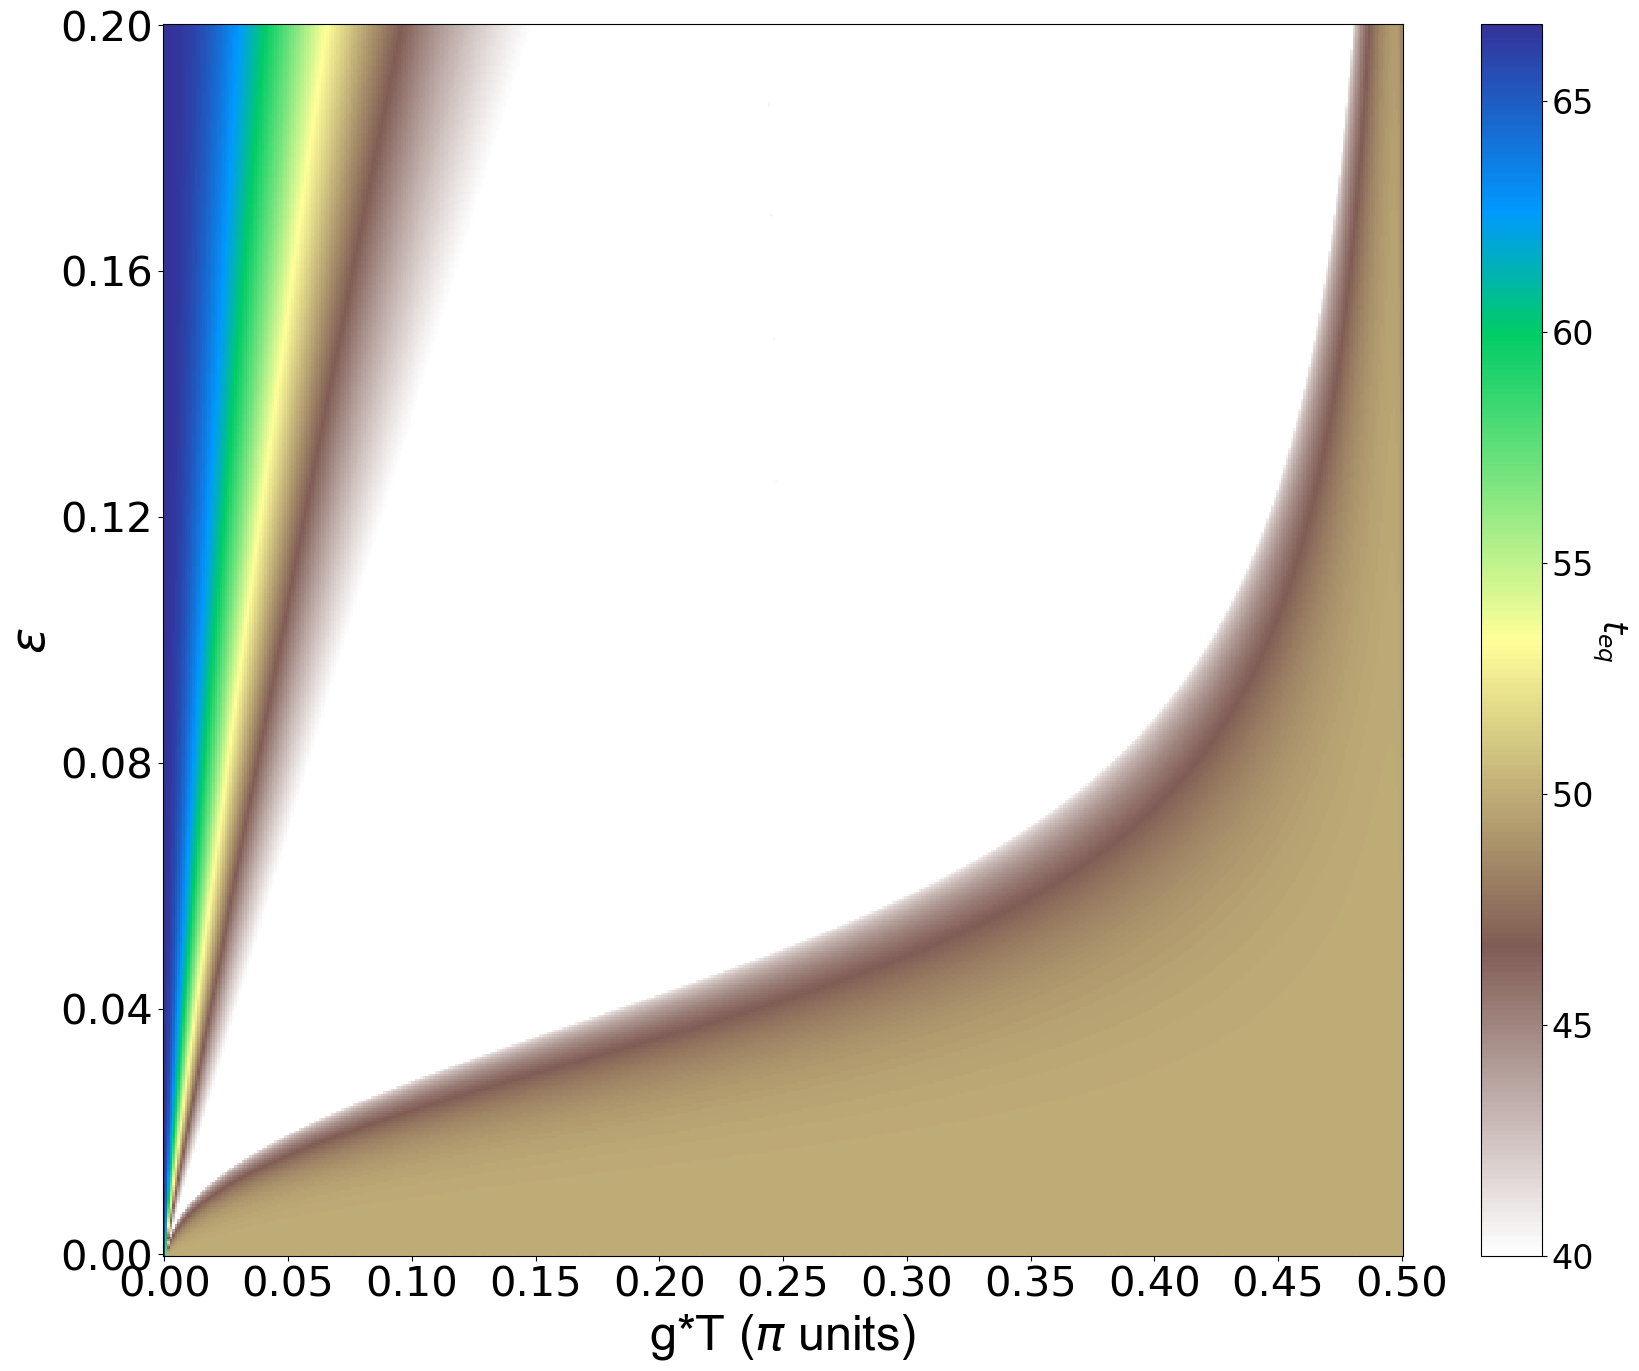

In [60]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(20, 16))

p = axes.pcolor(g/np.pi, eps, Spectral_gap, shading='nearest', cmap=cm.terrain_r)

axes.axis('tight')
axes.set_xlabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
axes.set_ylabel(r'$\epsilon$', fontsize=35, **hfont)

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$t_{eq}$', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=24) 
    
ymin, ymax = axes.get_ylim()
axes.set_yticks(np.round(np.linspace(ymin, ymax, 6), 2))

xmin, xmax = axes.get_xlim()
axes.set_xticks(np.round(np.linspace(xmin, xmax, 11), 2))

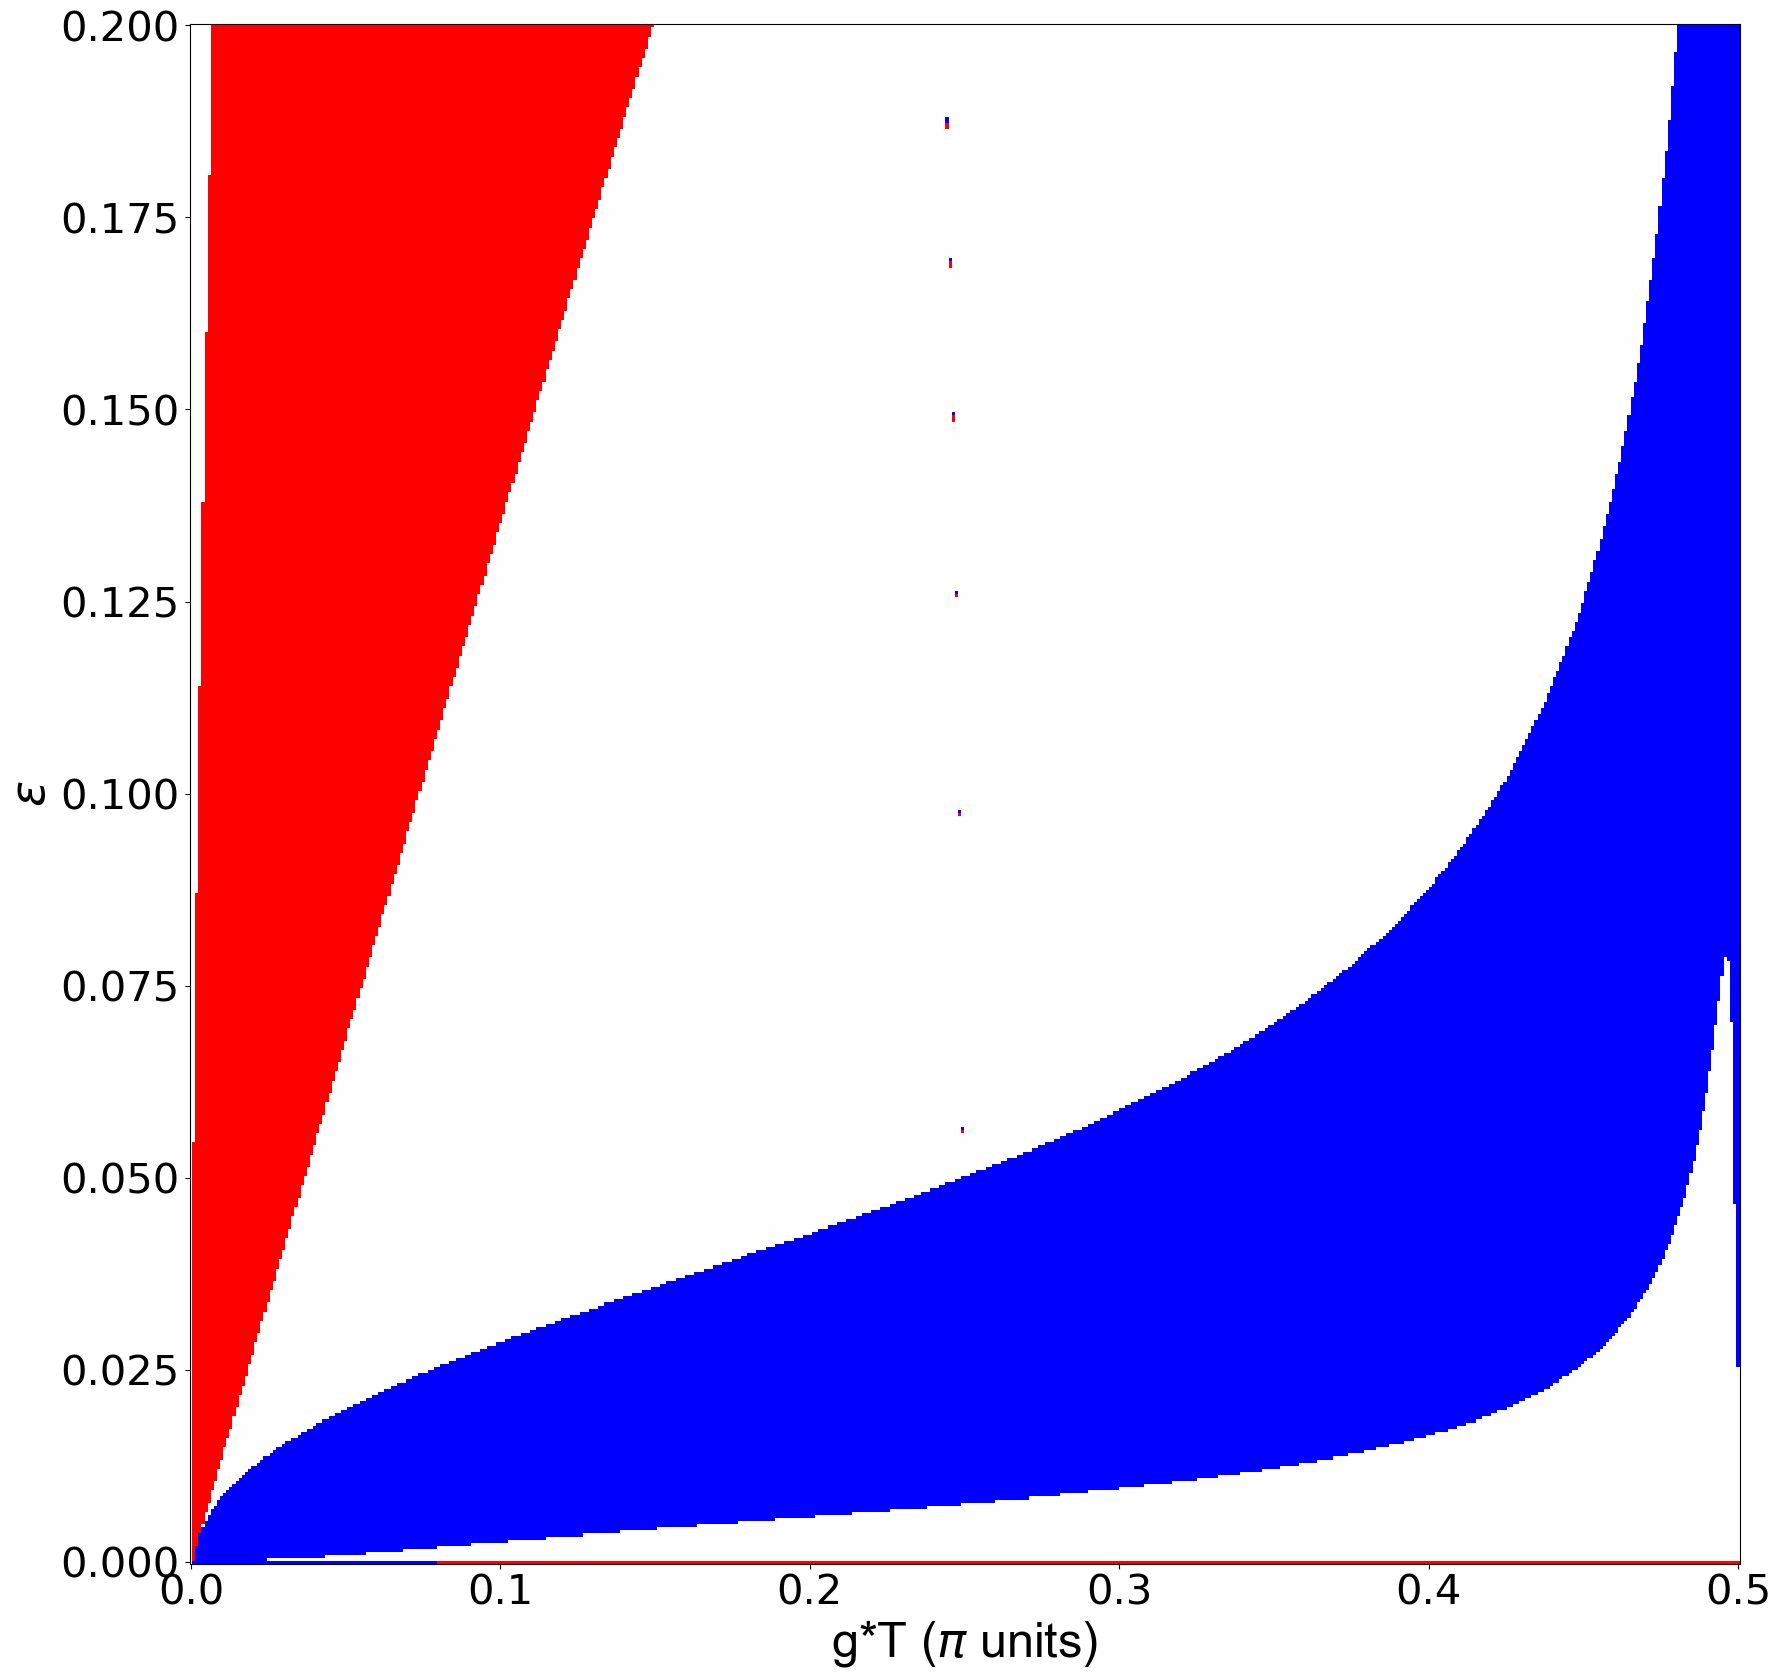

In [61]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(20, 20))

p = axes.pcolor(g/np.pi, eps, Piecewisese(Spectral_gap), shading='nearest', cmap=cm.bwr)

axes.axis('tight')
axes.set_xlabel(r'g*T ($\pi$ units)', fontsize=35, **hfont)
axes.set_ylabel(r'$\epsilon$', fontsize=35, **hfont)

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)